### Welcome to our Credit Default Risk Prediction Model
#### Team Members: Blythe Berlinger, Luke Brothers, Annie Peak, and Nathaniel Yee
#### Date: November 14th, 2024
#### Group Number:
#### Professor Yang

In [1]:
# Imports
import scipy
import statsmodels as sm
import sklearn as sk
import numpy as np
import altair as alt
import seaborn as sns
import plotly.express as px
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import dunnett

In [2]:
# Load in the data using pandas
cdr_file = 'credit_risk_dataset.csv'
cdr_data = pd.read_csv(cdr_file)

# Remove data points that are missing values
cdr_data_clean = cdr_data.dropna()
cdr_data_clean.sort_values('loan_grade',ascending=True)

cdr_data_clean

# Save directory for charts
output_dir = "images/"
os.makedirs(output_dir, exist_ok=True)

In [3]:
# Bar Chart, Loan Grade Counts 
cdr_data_clean_loan = cdr_data_clean['loan_grade'].value_counts().reset_index()
cdr_data_clean_loan.columns = ['loan_grade', 'count']

fig = px.bar(
    cdr_data_clean_loan,
    x='loan_grade',
    y='count',
    title='Loan Grade Counts',
    color='loan_grade',
    color_discrete_sequence=px.colors.sequential.RdBu
)

fig.update_layout(
    xaxis_title='Loan Grade',
    yaxis_title='Count',
    showlegend=False  
)

fig.write_image(f"{output_dir}loan_grade_counts.png")
fig.show()


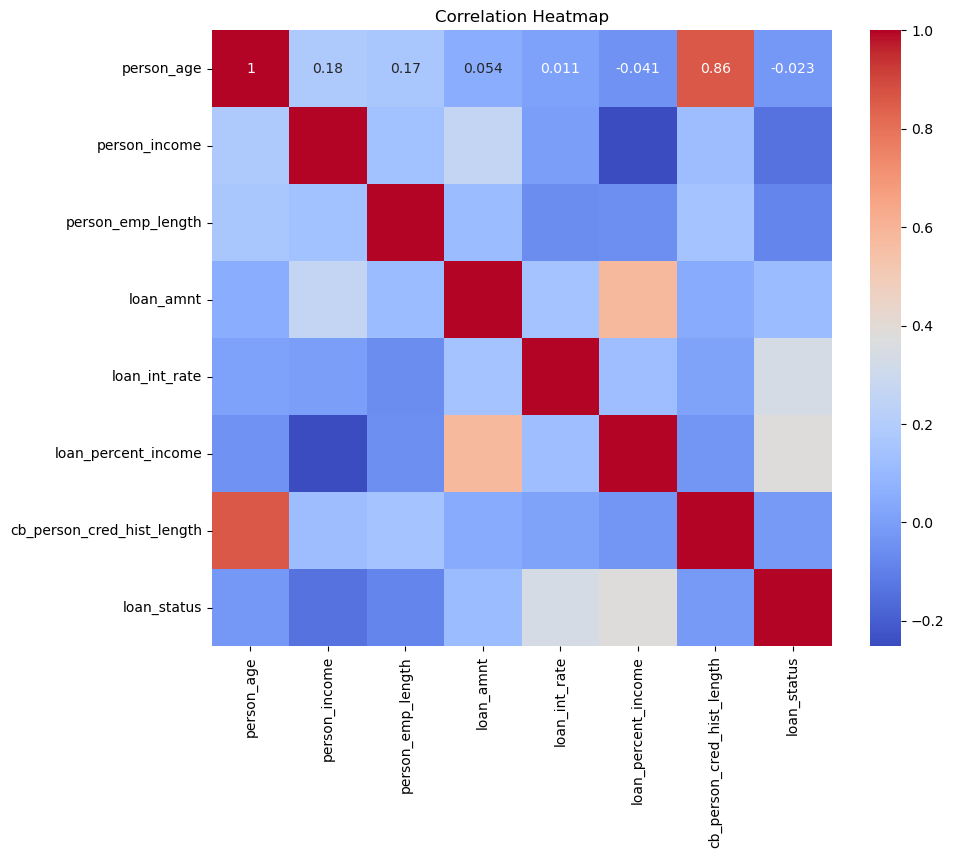

In [4]:
# Correlation heatmap
numeric_columns = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
correlation = cdr_data_clean[numeric_columns + ['loan_status']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig(f"{output_dir}correlation_heatmap.png", bbox_inches='tight') 
plt.show()

Visualizes the strength and direction of relationships between variables like loan_int_rate, loan_amnt, and person_income with loan_status.
Helps identify strong predictors of default risk 

In [5]:
# Scattar plot Interest Rate vs. Income by Loan Status
fig_scatter = px.scatter(
    cdr_data_clean, 
    x='loan_int_rate', 
    y='person_income', 
    color='loan_status', 
    title='Interest Rate vs. Income by Loan Status'
)

fig_scatter.write_image(f"{output_dir}interest_rate_vs_income.png")
fig_scatter.show()

Scatter plots for loan_int_rate vs. loan_status: Demonstrates whether higher interest rates lead to increased default likelihood.

In [6]:
# Bar plot of loan status by loan grade
fig_bar_status = px.bar(
    cdr_data_clean.groupby('loan_grade')['loan_status'].value_counts(normalize=True).unstack().reset_index(),
    x='loan_grade',
    y=[0, 1],  # 0: non-default, 1: default
    title='Loan Status by Loan Grade',
    barmode='group'
)

fig_bar_status.write_image(f"{output_dir}loan_status_by_grade.png")  # Save as PNG
fig_bar_status.show()


Count plots of loan_status by loan_grade: Higher grades (e.g., A, B) likely correspond to fewer defaults, while lower grades (e.g., D, E) have higher default rates.

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'] 
cdr_data_clean['loan_grade'] = pd.Categorical(cdr_data_clean['loan_grade'], categories=grade_order, ordered=True)

fig = px.box(
    cdr_data_clean, 
    x='loan_grade', 
    y='loan_int_rate', 
    color='loan_status', 
    title='Interest Rate by Loan Grade and Default Status',
    category_orders={"loan_grade": grade_order} 
)

fig.update_layout(
    xaxis_title='Loan Grade',
    yaxis_title='Interest Rate (%)'
)


fig.write_image(f"{output_dir}interest_rate_by_grade.png")  
fig.show()


Box plots of loan_int_rate by loan_grade: Shows how interest rates vary by grade and whether lower grades consistently have higher rates.

### Creating ML Model

In [9]:
# create dummy variables for non-numerical values and then cast them as integers
dummy = pd.get_dummies(cdr_data_clean,dtype=int)
# create correlation matrix to access collinearity
# dummy.corr()

In [10]:
# create important ratios for evaluation
dummy['loan_to_income_ratio'] = dummy['loan_amnt'] / dummy['person_income']
# Create loan-to-employment length ratio
dummy['loan_to_emp_length_ratio'] =  dummy['person_emp_length']/ dummy['loan_amnt'] 

# Create interest rate-to-loan amount ratio
dummy['int_rate_to_loan_amt_ratio'] = dummy['loan_int_rate'] / dummy['loan_amnt']


columns = ['loan_to_income_ratio','loan_to_emp_length_ratio','int_rate_to_loan_amt_ratio','loan_grade_A','loan_grade_B','loan_grade_C','loan_grade_D','loan_grade_E','loan_grade_F','loan_grade_G']
dummy = pd.DataFrame(dummy,columns=columns)
dummy

,loan_to_income_ratio,loan_to_emp_length_ratio,int_rate_to_loan_amt_ratio,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G
0,0.593220,0.003514,0.000458,0,0,0,1,0,0,0
1,0.104167,0.005000,0.011140,0,1,0,0,0,0,0
2,0.572917,0.000182,0.002340,0,0,1,0,0,0,0
3,0.534351,0.000114,0.000435,0,0,1,0,0,0,0
4,0.643382,0.000229,0.000408,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
32576,0.109434,0.000172,0.002269,0,0,1,0,0,0,0
32577,0.146875,0.000227,0.000425,1,0,0,0,0,0,0
32578,0.460526,0.000086,0.000314,0,1,0,0,0,0,0
32579,0.100000,0.000333,0.000765,0,1,0,0,0,0,0
